In [97]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mnist

#munge data from mnist
rawX = mnist.train_images().astype(np.float32)
def subsample(X,step=3):
    return np.array([im[0::step,0::step] for im in X])
rawX = subsample(rawX)
rawX = rawX[:,1:9,1:9] #remove row around edges of images (rarely used)

allX = rawX.reshape(60000,np.prod(rawX.shape[1:])) #flatten it
ally = mnist.train_labels()
keep = ally<2
allX = allX[keep,:]
ally = ally[keep]
ally = ally[:,None]
X = allX[0:300,:]
y = ally[0:300,:]
testX = allX[500:600,:]
testy = ally[500:600,:]

# GP Simple Classifier

Here we demonstrate attacking the simple GP classifier

In [98]:
#build model
from GPadversarial import simple
m = simple.build_model(X,y)
est = simple.calc_df_dx(m,testX[0:1,:].copy())

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s27  0018   2.548342e+01   8.847735e-04 
    02s87  0034   2.133011e+01   7.352433e-11 
Runtime:     02s87
Optimization status: Converged



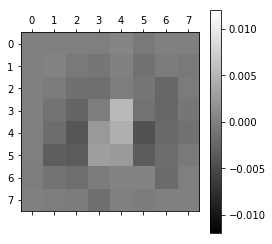

In [99]:
#let's see the saliency map
plt.matshow(est.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()

0.0011282141513386736

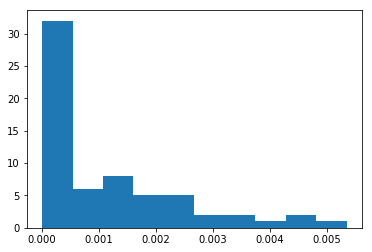

In [101]:
plt.hist(np.abs(est))
np.mean(np.abs(est))

In [102]:
tempest = np.zeros(testX.shape[1])
for t in range(10):
    tempest += np.abs(simple.calc_df_dx(m,testX[t:(t+1),:].copy()))

use = np.where(np.abs(est)>(np.mean(np.abs(est))/1))[0]
print(len(use))

26


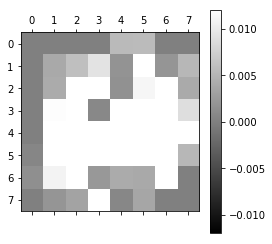

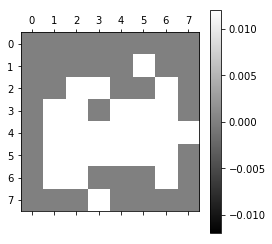

In [103]:
plt.matshow(tempest.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()
temp = np.zeros_like(tempest)
temp[use]=1
plt.matshow(temp.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()

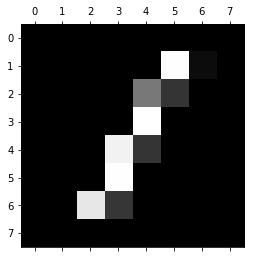

In [104]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [84]:
N = len(use)
adv = advX.copy()
for it in range(2):
    adv = adv.repeat(N,0)
    for i in use:
        adv[i::N,i]=255
        
lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(2):
        b = b.repeat(N,0)
        for i in use: #range(N):
            b[i::N,i]=255
    preds = m.predict(b)[0]
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi]

[ 0.42040728]


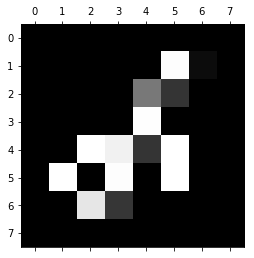

In [48]:
print(lowest)
plt.matshow(lowestim.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

# GP LVM

In [9]:
#build model
from GPadversarial import lvm
m, clf = lvm.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s04  002   1.146396e+07   1.928151e+13 
    00s19  007   2.156860e+06   4.935604e+10 
    01s74  102   9.257820e+04   7.928779e+02 
Runtime:     01s74
Optimization status: Maximum number of f evaluations reached



 /home/mike/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [21]:
m.rbf.lengthscale = 1000 #longer lengthscale better?
m.optimize()

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1
 /home/mike/GPy/GPy/kern/src/stationary.py:158: RuntimeWarning:overflow encountered in true_divide
 /home/mike/GPy/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /home/mike/GPy/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add


In [23]:
m.rbf.lengthscale

index,GPLVM.rbf.lengthscale,constraints,priors
[0],292.89276903,+ve,
[1],701.53234248,+ve,
[2],762.70378271,+ve,
[3],570.20913547,+ve,


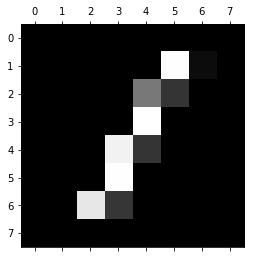

In [24]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [25]:
N = len(use)
adv = advX.copy()
for it in range(2):
    adv = adv.repeat(N,0)
    for i in use:
        adv[i::N,i]=255
        
lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(2):
        b = b.repeat(N,0)
        for i in use: #range(N):
            b[i::N,i]=255
    preds = lvm.get_pred(m,clf,b)
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi]

[ 12.3789685]


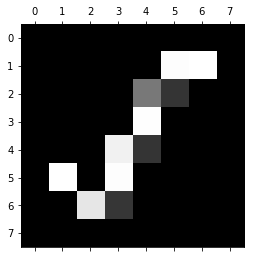

In [28]:
print(lowest)
plt.matshow(lowestim.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

# GPLVM + GP

In [105]:
#build model
from GPadversarial import lvm_gp
m, m2 = lvm_gp.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        

    01s05  021   1.798529e+05   3.405281e+08 
    03s86  103   1.015842e+05   3.964875e+02 
Runtime:     03s86
Optimization status: Maximum number of f evaluations reached



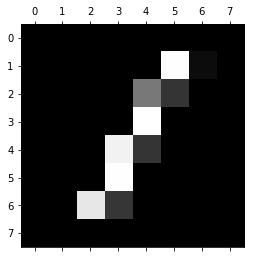

In [106]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [107]:
N = len(use)
adv = advX.copy()
for it in range(3):
    adv = adv.repeat(N,0)
    for i in use:
        adv[i::N,i]=255
        
lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    if (it%20==0):
        print("%0.0f%%" % (100.0*it/len(adv)))
    b = adv[it,:][None,:]
    for it in range(2):
        b = b.repeat(N,0)
        for i in use: #range(N):
            b[i::N,i]=255
    preds = lvm_gp.get_pred(m,m2,b)
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi,:]

0%


 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


0%
0%
0%
0%
1%
1%
1%
1%
1%
1%
1%
1%
1%
2%
2%
2%
2%
2%
2%
2%
2%
3%
3%
3%
3%
3%
3%
3%
3%
3%
4%
4%
4%
4%
4%
4%
4%
4%
4%
5%
5%
5%
5%
5%
5%
5%
5%
5%
6%
6%
6%
6%
6%
6%
6%
6%
6%
7%
7%
7%
7%
7%
7%
7%
7%
8%
8%
8%
8%
8%
8%
8%
8%
8%
9%
9%
9%
9%
9%
9%
9%
9%
9%
10%
10%
10%
10%
10%
10%
10%
10%
10%
11%
11%
11%
11%
11%
11%
11%
11%
11%
12%
12%
12%
12%
12%
12%
12%
12%
13%
13%
13%
13%
13%
13%
13%
13%
13%
14%
14%
14%
14%
14%
14%
14%
14%
14%
15%
15%
15%
15%
15%
15%
15%
15%
15%
16%
16%
16%
16%
16%
16%
16%
16%
16%
17%
17%
17%
17%
17%
17%
17%
17%
18%
18%
18%
18%
18%
18%
18%
18%
18%
19%
19%
19%
19%
19%
19%
19%
19%
19%
20%
20%
20%
20%
20%
20%
20%
20%
20%
21%
21%
21%
21%
21%
21%
21%
21%
22%
22%
22%
22%
22%
22%
22%
22%
22%
23%
23%
23%
23%
23%
23%
23%
23%
23%
24%
24%
24%
24%
24%
24%
24%
24%
24%
25%
25%
25%
25%
25%
25%
25%
25%
25%
26%
26%
26%
26%
26%
26%
26%
26%
27%
27%
27%
27%
27%
27%
27%
27%
27%
28%
28%
28%
28%
28%
28%
28%
28%
28%
29%
29%
29%
29%
29%
29%
29%
29%
29%
30%
30%
30%
30%
30%
30%
30%
30%
30%
31%
31%
31%

KeyboardInterrupt: 

In [108]:
lowest

array([ 0.94046001])

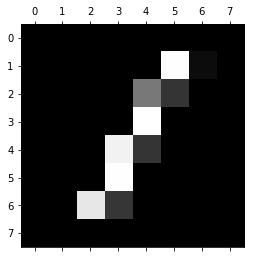

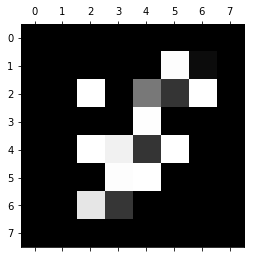

In [109]:
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
plt.figure()
plt.matshow(lowestim.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [110]:
latent_newX = m.infer_newX(lowestim[None,:])[0]
latent_originalX = m.infer_newX(advX)[0]

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


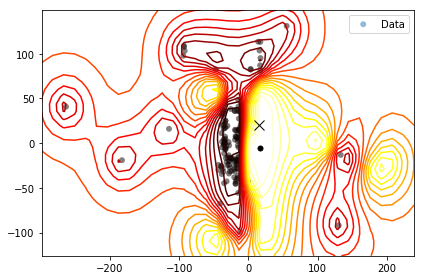

In [94]:
m2.plot()
plt.plot(latent_newX[0,0],latent_newX[0,1],'kx',markersize=10)
plt.plot(latent_originalX[0,0],latent_originalX[0,1],'k.',markersize=10)